<a href="https://colab.research.google.com/github/kdusousa/scva/blob/main/Projeto_SCVA_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

CÉLULA 1: MONTAR DRIVE & CAMINHOS

In [1]:
from pathlib import Path
from google.colab import drive

# Montar Google Drive
drive.mount('/content/drive')

BASE_DIR = Path('/content')
DRIVE_ROOT = Path('/content/drive/MyDrive/SCVA')

# Caminhos principais do projeto
DATASETS_DIR = DRIVE_ROOT / 'datasets'
REPOS_DIR    = DRIVE_ROOT / 'repos'
OUTPUT_DIR   = DRIVE_ROOT / 'outputs' / 'tumtraf_v2x_devkit_baseline'

# Caminho do TUMTraf V2X mini
TUMTRAF_V2X_DIR = DATASETS_DIR / 'tumtraf_v2x_cooperative_perception_dataset_mini'

# Diretório onde o dev-kit ficará clonado
DEVKIT_DIR = REPOS_DIR / 'tum-traffic-dataset-dev-kit'

for d in [DRIVE_ROOT, DATASETS_DIR, REPOS_DIR, OUTPUT_DIR]:
    d.mkdir(parents=True, exist_ok=True)

print("DRIVE_ROOT:", DRIVE_ROOT)
print("DATASETS_DIR:", DATASETS_DIR)
print("TUMTRAF_V2X_DIR existe?", TUMTRAF_V2X_DIR.exists())
print("DEVKIT_DIR:", DEVKIT_DIR)
print("OUTPUT_DIR:", OUTPUT_DIR)


Mounted at /content/drive
DRIVE_ROOT: /content/drive/MyDrive/SCVA
DATASETS_DIR: /content/drive/MyDrive/SCVA/datasets
TUMTRAF_V2X_DIR existe? True
DEVKIT_DIR: /content/drive/MyDrive/SCVA/repos/tum-traffic-dataset-dev-kit
OUTPUT_DIR: /content/drive/MyDrive/SCVA/outputs/tumtraf_v2x_devkit_baseline


Instalação de Dependências e Imports

In [2]:

# open3d
try:
    import open3d as o3d
    print("Open3D já instalado:", o3d.__version__)
except Exception:
    !pip install -q open3d
    import open3d as o3d
    print("Open3D instalado:", o3d.__version__)


import os
import sys
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import textwrap, subprocess
import torch


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.7/447.7 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 83.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 62.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 60.1 MB/s eta 0:00:00
Open3D instalado: 0.19.0


APENAS SE FOR RODAR O DEVKIT

In [3]:
!pip install bitarray
!pip install distinctipy

# Corrige erro XDG_RUNTIME_DIR
os.environ["XDG_RUNTIME_DIR"] = "/tmp/runtime-dir"
os.makedirs("/tmp/runtime-dir", exist_ok=True)

# Força modo CPU (sem tentar GPU/EGL fancy)
os.environ["OPEN3D_CPU_RENDERING"] = "true"

print("XDG_RUNTIME_DIR:", os.environ["XDG_RUNTIME_DIR"])
print("OPEN3D_CPU_RENDERING:", os.environ["OPEN3D_CPU_RENDERING"])


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 340.3/340.3 kB 25.1 MB/s eta 0:00:00
XDG_RUNTIME_DIR: /tmp/runtime-dir
OPEN3D_CPU_RENDERING: true


In [4]:
!apt-get update -qq
!apt-get install -y xvfb > /dev/null

!pip install -q pyvirtualdisplay

from pyvirtualdisplay import Display

display = Display(visible=0, size=(1280, 720))
display.start()


print("DISPLAY:", os.environ.get("DISPLAY"))


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
DISPLAY: :0


Download DevKit

In [5]:

DEVKIT_URL = "https://github.com/tum-traffic-dataset/tum-traffic-dataset-dev-kit.git"

if not DEVKIT_DIR.exists():
    !git clone {DEVKIT_URL} {DEVKIT_DIR}
else:
    print("Repositório já existe em:", DEVKIT_DIR)

# Mostrar commit atual (para congelamento)
%cd {DEVKIT_DIR}
!git rev-parse HEAD

# Voltar para /content
%cd /content


sys.path.append(str(DEVKIT_DIR))
print("DEVKIT_DIR adicionado ao PYTHONPATH.")


Repositório já existe em: /content/drive/MyDrive/SCVA/repos/tum-traffic-dataset-dev-kit
/content/drive/MyDrive/SCVA/repos/tum-traffic-dataset-dev-kit
a11c99b5b7f80b5fd1d8a2c9398fd6d21b4c80e2
/content
DEVKIT_DIR adicionado ao PYTHONPATH.


In [6]:

pcd_dir = TUMTRAF_V2X_DIR / 'train' / 'point_clouds' / 's110_lidar_ouster_south_and_vehicle_lidar_robosense_registered'
labels_dir = TUMTRAF_V2X_DIR / 'train' / 'labels_point_clouds' / 's110_lidar_ouster_south_and_vehicle_lidar_robosense_registered'

print("PCD dir:", pcd_dir)
print("Labels dir:", labels_dir)
print("PCD dir existe?", pcd_dir.exists())
print("Labels dir existe?", labels_dir.exists())

if pcd_dir.exists():
    pcd_files = sorted(list(pcd_dir.glob("*.pcd")))
    print(f"Qtd PCDs: {len(pcd_files)}")
    print("Exemplo PCD:", pcd_files[0].name if pcd_files else "nenhum")

if labels_dir.exists():
    json_files = sorted(list(labels_dir.glob("*.json")))
    print(f"Qtd JSON labels: {len(json_files)}")
    print("Exemplo JSON:", json_files[0].name if json_files else "nenhum")


PCD dir: /content/drive/MyDrive/SCVA/datasets/tumtraf_v2x_cooperative_perception_dataset_mini/train/point_clouds/s110_lidar_ouster_south_and_vehicle_lidar_robosense_registered
Labels dir: /content/drive/MyDrive/SCVA/datasets/tumtraf_v2x_cooperative_perception_dataset_mini/train/labels_point_clouds/s110_lidar_ouster_south_and_vehicle_lidar_robosense_registered
PCD dir existe? True
Labels dir existe? True
Qtd PCDs: 400
Exemplo PCD: 1688625741_046595374_s110_lidar_ouster_south_and_vehicle_lidar_robosense_registered.pcd
Qtd JSON labels: 400
Exemplo JSON: 1688625741_046595374_s110_lidar_ouster_south_and_vehicle_lidar_robosense_registered.json


Saída para imagens geradas

In [7]:

OUT_VIS_DIR = Path("/content/drive/MyDrive/SCVA/outputs/baseline_bev")
OUT_VIS_DIR.mkdir(parents=True, exist_ok=True)

print("Saída:", OUT_VIS_DIR)



Saída: /content/drive/MyDrive/SCVA/outputs/baseline_bev


GERAÇÃO DE IMAGENS - NÃO PRECISA RODAR (O script foi editado para o nosso propósito)

In [ ]:
%cd {DEVKIT_DIR}

#!python src/visualization/visualize_point_cloud_with_3d_boxes.py \
#    --input_folder_path_point_clouds "{pcd_dir}" \
#    --input_folder_path_labels "{labels_dir}" \
#    --save_visualization_results \
#    --view "bev" \
#    --output_folder_path_visualization_results "{OUT_VIS_DIR}" \
#    --show_hd_map



In [8]:

imgs = sorted(OUT_VIS_DIR.glob("*.png"))
print("Qtd imagens:", len(imgs))
for img in imgs[:10]:
    print(img.name)



Qtd imagens: 400
1688625741_046595374_s110_lidar_ouster_south_and_vehicle_lidar_robosense_registered.png
1688625741_146525143_s110_lidar_ouster_south_and_vehicle_lidar_robosense_registered.png
1688625741_246475530_s110_lidar_ouster_south_and_vehicle_lidar_robosense_registered.png
1688625741_346320075_s110_lidar_ouster_south_and_vehicle_lidar_robosense_registered.png
1688625741_546330924_s110_lidar_ouster_south_and_vehicle_lidar_robosense_registered.png
1688625741_646360135_s110_lidar_ouster_south_and_vehicle_lidar_robosense_registered.png
1688625741_746430273_s110_lidar_ouster_south_and_vehicle_lidar_robosense_registered.png
1688625741_848606908_s110_lidar_ouster_south_and_vehicle_lidar_robosense_registered.png
1688625742_046700422_s110_lidar_ouster_south_and_vehicle_lidar_robosense_registered.png
1688625742_146513298_s110_lidar_ouster_south_and_vehicle_lidar_robosense_registered.png


SPOOF NO LABEL (JSON) - INSERÇÃO




In [9]:
import json
import uuid
import copy
import numpy as np

def create_spoofed_json_openlabel(
    original_json_path,
    output_json_path,
    n_phantoms=3,
    x_range=(10, 30),
    y_range=(-5, 5),
    z_fixed=-1.5,
    lwh=(4.0, 1.8, 1.6),
    yaw_range=(-3.14, 3.14)
):
    """
    Cria um JSON spoofado adicionando objetos PHANTOM em formato OpenLABEL.

    - Mantém todos os objetos originais.
    - Insere N phantoms com caixas 3D completas.
    - Usa type="PHANTOM" para que o DevKit renderize em vermelho.
    """

    # ----------------------------------------------------------------------
    # 1. Carregar JSON original
    # ----------------------------------------------------------------------
    with open(original_json_path, "r") as f:
        data = json.load(f)

    # Verificação básica
    if "openlabel" not in data:
        raise RuntimeError("JSON não está no formato OpenLABEL!")

    frames = data["openlabel"]["frames"]
    if len(frames) != 1:
        raise RuntimeError("Esperado exatamente 1 frame no JSON.")

    frame_key = list(frames.keys())[0]  # normalmente "1"
    frame_data = frames[frame_key]

    original_objects = frame_data.get("objects", {})
    spoofed_objects = copy.deepcopy(original_objects)

    # ----------------------------------------------------------------------
    # 2. Inserir PHANTOMS
    # ----------------------------------------------------------------------
    for i in range(n_phantoms):
        # IDs únicos para cada phantom
        phantom_id = str(uuid.uuid4())

        # Posição e orientação aleatória dentro dos ranges
        x = np.random.uniform(*x_range)
        y = np.random.uniform(*y_range)
        z = z_fixed
        yaw = np.random.uniform(*yaw_range)

        length, width, height = lwh

        # Formato OpenLABEL (exatamente o que o DevKit exige)
        spoofed_objects[phantom_id] = {
            "object_data": {
                "type": "PHANTOM",
                "name": f"PHANTOM_{i}",
                "cuboid": {
                    "name": "shape3D",
                    # VALOR OFICIAL OPENLABEL (TUMTraf usa esse formato):
                    # [x, y, z, qx, qy, qz, qw, length, width, height]
                    "val": [
                        float(x),
                        float(y),
                        float(z),
                        0.0, 0.0, np.sin(yaw/2), np.cos(yaw/2),
                        float(length),
                        float(width),
                        float(height)
                    ]
                }
            }
        }

        # ----------------------------------------------------------------------
    # 3. Reescrever JSON com objetos spoofados
    # ----------------------------------------------------------------------
    frames[frame_key]["objects"] = spoofed_objects

    with open(output_json_path, "w") as f:
        json.dump(data, f, indent=2)

    print(f"[OK] JSON spoofado salvo em:\n{output_json_path}")




SPOOF NO LABEL (JSON) - SUPRESSÃO

In [ ]:
import json
import copy
import numpy as np
from pathlib import Path


def create_removed_json_openlabel(
    original_json_path,
    output_json_path,
    remove_mode="random",   # "random", "roi", "class"
    n_remove=3,
    roi_x=(10, 40),         # se modo = "roi"
    roi_y=(-10, 10),
    class_to_remove="CAR"   # se modo = "class"
):
    """
    CONCEALMENT / BLINDSPOT INDUCTION
    Remove objetos legítimos do JSON TUMTraf (OpenLABEL)
    para simular ocultação semântica.

    Parâmetros:
        remove_mode:
            - "random": remove n_remove objetos aleatórios
            - "roi": remove todos objetos dentro de ROI
            - "class": remove objetos de uma classe específica

        n_remove:
            usado no modo "random"
    """

    # ------------------------------------------------------------
    # 1. Carregar JSON original
    # ------------------------------------------------------------
    with open(original_json_path, "r") as f:
        data = json.load(f)

    frames = data["openlabel"]["frames"]
    frame_key = list(frames.keys())[0]
    frame_data = frames[frame_key]

    original_objects = frame_data.get("objects", {})
    new_objects = copy.deepcopy(original_objects)

    # Criar lista de objetos com coordenadas e classe
    obj_list = []

    for oid, obj in original_objects.items():
        try:
            cuboid = obj["object_data"]["cuboid"]["val"]
            class_name = obj["object_data"]["type"]
            x, y, z = cuboid[0], cuboid[1], cuboid[2]
            obj_list.append((oid, x, y, z, class_name))
        except:
            continue

    # ------------------------------------------------------------
    # 2. APLICAR MODO DE REMOÇÃO
    # ------------------------------------------------------------

    objects_to_remove = []

    # === MODO A: REMOÇÃO ALEATÓRIA ==============================
    if remove_mode == "random":
        if isinstance(n_remove, str) and n_remove.lower() == "random":
          n_remove = np.random.randint(1, 10)
        if n_remove > 0 and len(obj_list) > 0:
            selected = np.random.choice(len(obj_list), size=min(n_remove, len(obj_list)), replace=False)
            objects_to_remove = [obj_list[i][0] for i in selected]

    # === MODO B: REMOÇÃO POR REGIÃO =============================
    elif remove_mode == "roi":
        for oid, x, y, z, cls in obj_list:
            if roi_x[0] <= x <= roi_x[1] and roi_y[0] <= y <= roi_y[1]:
                objects_to_remove.append(oid)

    # === MODO C: REMOÇÃO POR CLASSE =============================
    elif remove_mode == "class":
        for oid, x, y, z, cls in obj_list:
            if cls.upper() == class_to_remove.upper():
                objects_to_remove.append(oid)

    # ------------------------------------------------------------
    # 3. Remover objetos selecionados
    # ------------------------------------------------------------
    for oid in objects_to_remove:
        if oid in new_objects:
            del new_objects[oid]

    # ------------------------------------------------------------
    # 4. Salvar JSON modificado
    # ------------------------------------------------------------
    frames[frame_key]["objects"] = new_objects

    with open(output_json_path, "w") as f:
        json.dump(data, f, indent=2)

    print(f"[OK] JSON concealing salvo em:\n{output_json_path}")
    print(f"[INFO] Objetos removidos: {len(objects_to_remove)}")
    return objects_to_remove


RODAR SPOOF EM TODOS OS FRAMES

In [10]:
from pathlib import Path
import numpy as np

def spoof_all_json_in_folder(
    input_json_dir,
    output_json_dir,
    attack_type="phantom",   # "phantom", "remove_random", "remove_roi", "remove_class"
    # --- parâmetros do ataque A (phantom injection) ---
    n_phantoms=3,
    x_range=(10, 30),
    y_range=(-5, 5),
    z_fixed=-1.5,
    lwh=(4.0, 1.8, 1.6),
    yaw_range=(-3.14, 3.14),
    # --- parâmetros do ataque B (concealment) ---
    n_remove=3,
    roi_x=(10, 40),
    roi_y=(-10, 10),
    class_to_remove="CAR"
):
    """
    Aplica um ATAQUE a TODOS os arquivos JSON de um diretório TUMTraf.

    attack_type:
        - "phantom"       -> Ataque A: injeta PHANTOMs (create_spoofed_json_openlabel)
        - "remove_random" -> Ataque B: remove n_remove objetos aleatórios
        - "remove_roi"    -> Ataque B: remove objetos dentro de ROI (roi_x, roi_y)
        - "remove_class"  -> Ataque B: remove objetos de uma classe (class_to_remove)

    input_json_dir: diretório com os JSON originais (_labels_point_clouds)
    output_json_dir: diretório onde serão salvos os JSON atacados
    """

    input_json_dir  = Path(input_json_dir)
    output_json_dir = Path(output_json_dir)
    output_json_dir.mkdir(parents=True, exist_ok=True)

    json_files = sorted(input_json_dir.glob("*.json"))
    print(f"[INFO] Total de arquivos encontrados: {len(json_files)}")
    print(f"[INFO] Ataque selecionado: {attack_type}")

    for jpath in json_files:
        out_path = output_json_dir / jpath.name
        print(f"[PROCESSANDO] {jpath.name}")

        if attack_type == "phantom":
            # ATAQUE A – Injeção de PHANTOMs
            create_spoofed_json_openlabel(
                original_json_path=jpath,
                output_json_path=out_path,
                n_phantoms=n_phantoms,
                x_range=x_range,
                y_range=y_range,
                z_fixed=z_fixed,
                lwh=lwh,
                yaw_range=yaw_range
            )

        elif attack_type in ("remove_random", "remove_roi", "remove_class"):
            # ATAQUE B – Concealment / Blindspot
            if attack_type == "remove_random":
                remove_mode = "random"
            elif attack_type == "remove_roi":
                remove_mode = "roi"
            else:
                remove_mode = "class"

            create_removed_json_openlabel(
                original_json_path=jpath,
                output_json_path=out_path,
                remove_mode=remove_mode,
                n_remove=n_remove,
                roi_x=roi_x,
                roi_y=roi_y,
                class_to_remove=class_to_remove
            )

        else:
            print(f"[AVISO] attack_type '{attack_type}' não reconhecido. Pulando {jpath.name}.")
            continue

    print(f"[OK] Todos os JSON foram processados e salvos em:\n{output_json_dir}")


In [ ]:
##REMOÇÃO ROI
INPUT_JSON_DIR  = "/content/drive/MyDrive/SCVA/datasets/tumtraf_v2x_cooperative_perception_dataset_mini/train/labels_point_clouds/s110_lidar_ouster_south_and_vehicle_lidar_robosense_registered/"
OUTPUT_JSON_DIR = "/content/drive/MyDrive/SCVA/datasets/tumtraf_spoof/labels_attackB_roi/"

spoof_all_json_in_folder(
    INPUT_JSON_DIR ,
    OUTPUT_JSON_DIR,
    attack_type="remove_roi",
    roi_x=(10, 30),
    roi_y=(-5, 5),
)

In [ ]:
##GERAÇÃO DE IMAGENS ROI
%cd {DEVKIT_DIR}
OUT_SPOOF_DIR = Path("/content/drive/MyDrive/SCVA/outputs/spoof_B_roi")
OUT_SPOOF_DIR.mkdir(parents=True, exist_ok=True)

print("Saída:", OUT_SPOOF_DIR)




!python src/visualization/visualize_point_cloud_with_3d_boxes.py \
    --input_folder_path_point_clouds "{pcd_dir}" \
    --input_folder_path_labels "/content/drive/MyDrive/SCVA/datasets/tumtraf_spoof/labels_attackB_roi/" \
    --save_visualization_results \
    --view "bev" \
    --output_folder_path_visualization_results "{OUT_SPOOF_DIR}" \
    --show_hd_map

✔ Análises

In [12]:
## Leitura padronizada dos JSONs OpenLABEL (TUMTraf)

import json
from pathlib import Path
import numpy as np
import pandas as pd
from collections import Counter, defaultdict
import matplotlib.pyplot as plt

def load_openlabel_objects(json_path):
    """
    Lê um JSON OpenLABEL do TUMTraf e retorna uma lista de dicts:
    [
        {"id": "...", "cls": "CAR", "x": , "y": , "z": },
        ...
    ]
    """
    json_path = Path(json_path)
    with open(json_path, "r") as f:
        data = json.load(f)

    frames = data["openlabel"]["frames"]
    frame_key = list(frames.keys())[0]
    objs_raw = frames[frame_key].get("objects", {})

    objs = []
    for oid, obj in objs_raw.items():
        try:
            odata = obj["object_data"]
            cls = odata.get("type", "UNKNOWN").upper()

            val = odata["cuboid"]["val"]
            x, y, z = val[0], val[1], val[2]

            objs.append({
                "id": oid,
                "cls": cls,
                "x": float(x),
                "y": float(y),
                "z": float(z),
            })

        except:
            continue

    return objs


In [11]:
## Métricas computadas frame a frame

def compute_frame_metrics(
    json_base,
    json_spoof,
    roi_x=(10, 40),
    roi_y=(-10, 10)
):
    """
    Compara baseline x spoof (phantom, random ou roi).
    Retorna dicionário de métricas por frame.
    """

    base_objs  = load_openlabel_objects(json_base)
    spoof_objs = load_openlabel_objects(json_spoof)

    # contagem simples
    n_base  = len(base_objs)
    n_spoof = len(spoof_objs)
    delta_n = n_spoof - n_base

    # contagem por classe
    cnt_base  = Counter([o["cls"] for o in base_objs])
    cnt_spoof = Counter([o["cls"] for o in spoof_objs])

    # phantom influence index
    n_phantoms = cnt_spoof.get("PHANTOM", 0)
    total_phantoms_inserted = n_spoof - n_base if delta_n > 0 else 0
    PII = n_phantoms / total_phantoms_inserted if total_phantoms_inserted > 0 else 0

    # Scene Divergence Score
    SDS = abs(n_spoof - n_base) / max(n_base, 1)

    # ROI Impact Score (apenas para ataques de remoção)
    def inside_roi(o):
        return roi_x[0] <= o["x"] <= roi_x[1] and roi_y[0] <= o["y"] <= roi_y[1]

    base_roi = [o for o in base_objs if inside_roi(o)]
    spoof_roi = [o for o in spoof_objs if inside_roi(o)]

    n_base_roi  = len(base_roi)
    n_spoof_roi = len(spoof_roi)
    removed_roi = n_base_roi - n_spoof_roi

    ROI_impact = removed_roi / max(n_base_roi, 1)

    # empacotar tudo
    metrics = {
        "frame": Path(json_base).name,
        "n_base": n_base,
        "n_spoof": n_spoof,
        "delta_n": delta_n,
        "n_phantoms": n_phantoms,
        "phantom_infl_idx": PII,
        "scene_divergence": SDS,
        "n_base_roi": n_base_roi,
        "n_spoof_roi": n_spoof_roi,
        "roi_removed": removed_roi,
        "roi_impact": ROI_impact,
        "cnt_base": cnt_base,
        "cnt_spoof": cnt_spoof
    }

    return metrics


In [13]:
## 3. Processar uma pasta completa de baseline + spoof

def batch_process(
    baseline_dir,
    spoof_dir,
    roi_x=(10, 40),
    roi_y=(-10, 10)
):

    baseline_dir = Path(baseline_dir)
    spoof_dir = Path(spoof_dir)

    json_base_files = sorted(baseline_dir.glob("*.json"))

    results = []

    for jbase in json_base_files:
        spoof_path = spoof_dir / jbase.name

        if not spoof_path.exists():
            print(f"[WARN] Spoof não encontrado para {jbase.name}")
            continue

        metrics = compute_frame_metrics(jbase, spoof_path, roi_x, roi_y)
        results.append(metrics)

    return pd.DataFrame(results)


Gráficos principais para apresentação

In [14]:
## A. ΔN (baseline x spoof)

def plot_delta_n(df, title):
    plt.figure(figsize=(10,4))
    plt.plot(df["delta_n"], marker="o")
    plt.axhline(0, color="black", linewidth=1)
    plt.title(title)
    plt.ylabel("ΔN (n_spoof - n_base)")
    plt.xlabel("Frame")
    plt.grid(True)
    plt.show()

## B. Phantom Influence Index

def plot_pii(df):
    plt.figure(figsize=(6,4))
    plt.plot(df["phantom_infl_idx"], marker="o", color="red")
    plt.title("Phantom Influence Index")
    plt.xlabel("Frame")
    plt.ylabel("PII")
    plt.grid(True)
    plt.show()

## C. ROI Impact Score

def plot_roi_impact(df):
    plt.figure(figsize=(6,4))
    plt.plot(df["roi_impact"], marker="x", color="purple")
    plt.title("ROI Impact Score")
    plt.xlabel("Frame")
    plt.ylabel("Impacto (0–1)")
    plt.grid(True)
    plt.show()

## D. Scene Divergence Score (SDS)

def plot_sds(df):
    plt.figure(figsize=(6,4))
    plt.plot(df["scene_divergence"], marker="s", color="green")
    plt.title("Scene Divergence Score")
    plt.xlabel("Frame")
    plt.ylabel("SDS")
    plt.grid(True)
    plt.show()



✅ 5. Heatmap espacial dos objetos

In [15]:
def plot_heatmap(objects, title):
    xs = [o["x"] for o in objects]
    ys = [o["y"] for o in objects]

    plt.figure(figsize=(6,6))
    plt.hist2d(xs, ys, bins=40, cmap="hot")
    plt.colorbar()
    plt.title(title)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()


In [17]:
BASELINE_JSON_DIR = "/content/drive/MyDrive/SCVA/datasets/tumtraf_v2x_cooperative_perception_dataset_mini/train/labels_point_clouds/s110_lidar_ouster_south_and_vehicle_lidar_robosense_registered"
INJECT_JSON_DIR   = "/content/drive/MyDrive/SCVA/datasets/tumtraf_spoof/labels_attackA"
ROI_JSON_DIR      = "/content/drive/MyDrive/SCVA/datasets/tumtraf_spoof/labels_attackB_roi"
RANDOM_JSON_DIR   = "/content/drive/MyDrive/SCVA/datasets/tumtraf_spoof/labels_attackB_random"


In [ ]:
batch_process(
    BASELINE_JSON_DIR,
    INJECT_JSON_DIR,
    roi_x=(10, 40),
    roi_y=(-10, 10)
)

In [21]:
def process_roi_attack(baseline_dir, roi_dir):
    baseline_dir = Path(baseline_dir)
    roi_dir = Path(roi_dir)

    json_base_files = sorted(baseline_dir.glob("*.json"))
    results = []

    for jbase in json_base_files:
        spoof_path = roi_dir / jbase.name
        if not spoof_path.exists():
            print(f"[WARN] Spoof não encontrado para {jbase.name}")
            continue

        m = compute_frame_metrics(jbase, spoof_path)
        results.append(m)

    df = pd.DataFrame(results)
    return df

df_roi = process_roi_attack(BASELINE_JSON_DIR, ROI_JSON_DIR)
df_roi

,frame,n_base,n_spoof,delta_n,n_phantoms,phantom_infl_idx,scene_divergence,n_base_roi,n_spoof_roi,roi_removed,roi_impact,cnt_base,cnt_spoof
0,1688625741_046595374_s110_lidar_ouster_south_a...,27,27,0,0,0,0.000000,0,0,0,0.0,"{'BUS': 2, 'PEDESTRIAN': 3, 'TRAILER': 6, 'TRU...","{'BUS': 2, 'PEDESTRIAN': 3, 'TRAILER': 6, 'TRU..."
1,1688625741_146525143_s110_lidar_ouster_south_a...,27,27,0,0,0,0.000000,0,0,0,0.0,"{'BUS': 2, 'PEDESTRIAN': 3, 'TRAILER': 6, 'TRU...","{'BUS': 2, 'PEDESTRIAN': 3, 'TRAILER': 6, 'TRU..."
2,1688625741_246475530_s110_lidar_ouster_south_a...,27,27,0,0,0,0.000000,0,0,0,0.0,"{'TRAILER': 6, 'TRUCK': 6, 'BUS': 2, 'PEDESTRI...","{'TRAILER': 6, 'TRUCK': 6, 'BUS': 2, 'PEDESTRI..."
3,1688625741_346320075_s110_lidar_ouster_south_a...,27,27,0,0,0,0.000000,0,0,0,0.0,"{'TRAILER': 6, 'TRUCK': 6, 'BUS': 2, 'PEDESTRI...","{'TRAILER': 6, 'TRUCK': 6, 'BUS': 2, 'PEDESTRI..."
4,1688625741_546330924_s110_lidar_ouster_south_a...,27,27,0,0,0,0.000000,0,0,0,0.0,"{'TRAILER': 6, 'TRUCK': 6, 'BUS': 2, 'PEDESTRI...","{'TRAILER': 6, 'TRUCK': 6, 'BUS': 2, 'PEDESTRI..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,1688626672_540490735_s110_lidar_ouster_south_a...,31,30,-1,0,0,0.032258,1,0,1,1.0,"{'BUS': 1, 'CAR': 13, 'TRUCK': 5, 'PEDESTRIAN'...","{'BUS': 1, 'CAR': 13, 'TRUCK': 5, 'PEDESTRIAN'..."
396,1688626672_640467284_s110_lidar_ouster_south_a...,31,30,-1,0,0,0.032258,1,0,1,1.0,"{'BUS': 1, 'CAR': 13, 'TRUCK': 5, 'PEDESTRIAN'...","{'BUS': 1, 'CAR': 13, 'TRUCK': 5, 'PEDESTRIAN'..."
397,1688626672_740383884_s110_lidar_ouster_south_a...,31,30,-1,0,0,0.032258,1,0,1,1.0,"{'BUS': 1, 'CAR': 13, 'TRUCK': 5, 'PEDESTRIAN'...","{'BUS': 1, 'CAR': 13, 'TRUCK': 5, 'PEDESTRIAN'..."
398,1688626672_840311558_s110_lidar_ouster_south_a...,31,31,0,0,0,0.000000,1,1,0,0.0,"{'BUS': 1, 'CAR': 13, 'TRUCK': 5, 'PEDESTRIAN'...","{'BUS': 1, 'CAR': 13, 'TRUCK': 5, 'PEDESTRIAN'..."


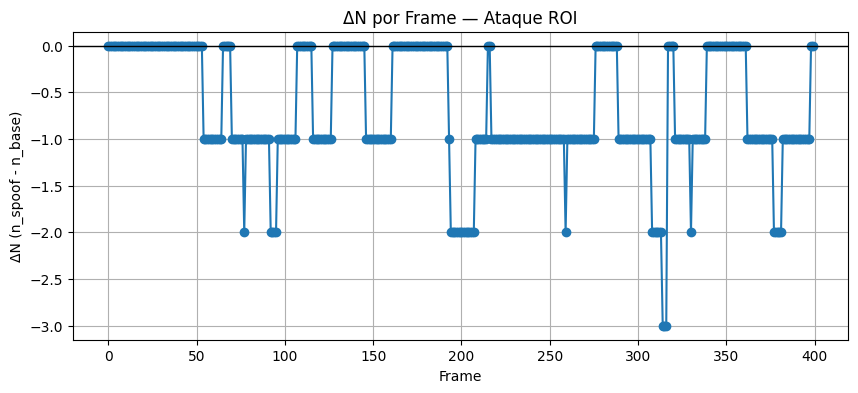

In [22]:
plot_delta_n(df_roi, "ΔN por Frame — Ataque ROI")


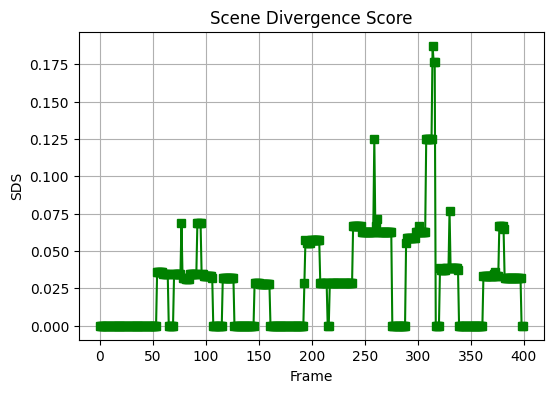

In [23]:
plot_sds(df_roi)


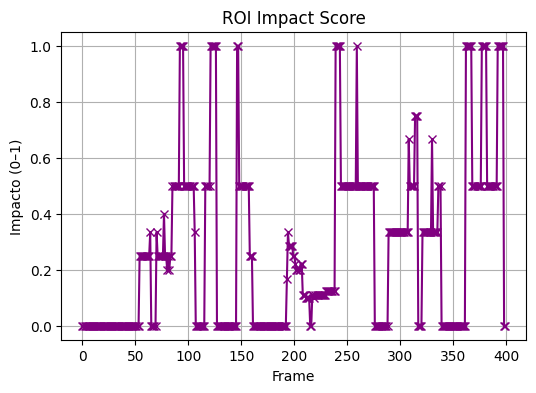

In [24]:
plot_roi_impact(df_roi)


In [25]:
df_roi[["delta_n", "scene_divergence", "roi_impact"]].describe()


,delta_n,scene_divergence,roi_impact
count,400.000000,400.000000,400.000000
mean,-0.687500,0.027926,0.273211
std,0.648765,0.030200,0.305476
min,-3.000000,0.000000,0.000000
25%,-1.000000,0.000000,0.000000
50%,-1.000000,0.028571,0.222222
75%,0.000000,0.038462,0.500000
max,0.000000,0.187500,1.000000


In [26]:
from pathlib import Path

def aggregate_objects_in_dir(json_dir):
    """
    Lê TODOS os .json em json_dir e agrega todos os objetos
    em uma única lista (para heatmap global).
    """
    json_dir = Path(json_dir)
    all_objs = []

    json_files = sorted(json_dir.glob("*.json"))
    print(f"[INFO] Encontrados {len(json_files)} arquivos em {json_dir}")

    for jpath in json_files:
        objs = load_openlabel_objects(jpath)
        all_objs.extend(objs)

    print(f"[INFO] Total de objetos agregados: {len(all_objs)}")
    return all_objs


In [28]:
base_all  = aggregate_objects_in_dir(BASELINE_JSON_DIR)
roi_all   = aggregate_objects_in_dir(ROI_JSON_DIR)
random_all = aggregate_objects_in_dir(RANDOM_JSON_DIR)
inject_all = aggregate_objects_in_dir(INJECT_JSON_DIR)

#plot_heatmap(base_all, "Baseline – densidade global (todos os frames)")
#plot_heatmap(roi_all,  "Ataque ROI – densidade global (todos os frames)")
#plot_heatmap(random_all, "Ataque Random – densidade global (todos os frames)")
#plot_heatmap(inject_all, "Ataque Phantom – densidade global (todos os frames)")

[INFO] Encontrados 400 arquivos em /content/drive/MyDrive/SCVA/datasets/tumtraf_v2x_cooperative_perception_dataset_mini/train/labels_point_clouds/s110_lidar_ouster_south_and_vehicle_lidar_robosense_registered
[INFO] Total de objetos agregados: 11118
[INFO] Encontrados 400 arquivos em /content/drive/MyDrive/SCVA/datasets/tumtraf_spoof/labels_attackB_roi
[INFO] Total de objetos agregados: 10843
[INFO] Encontrados 400 arquivos em /content/drive/MyDrive/SCVA/datasets/tumtraf_spoof/labels_attackB_random
[INFO] Total de objetos agregados: 9169
[INFO] Encontrados 400 arquivos em /content/drive/MyDrive/SCVA/datasets/tumtraf_spoof/labels_attackA
[INFO] Total de objetos agregados: 12318


Baseline   : 11118 objetos
Phantom    : 12318 objetos
Random del : 9169 objetos
ROI del    : 10843 objetos


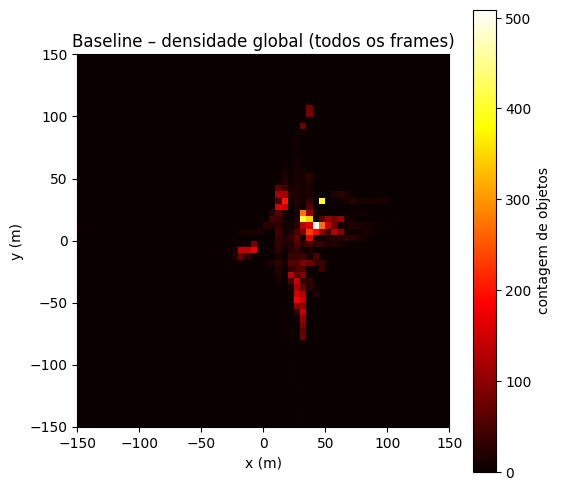

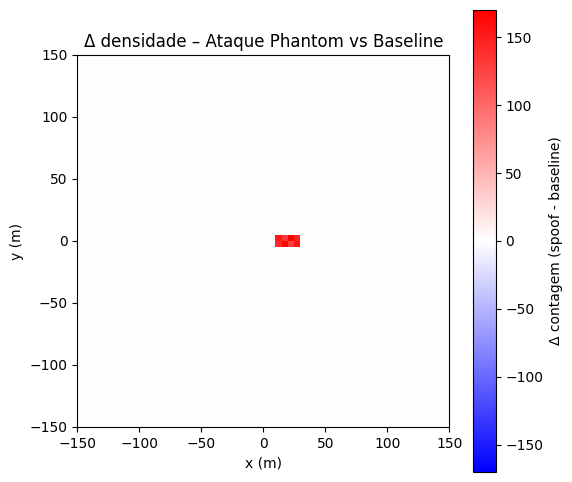

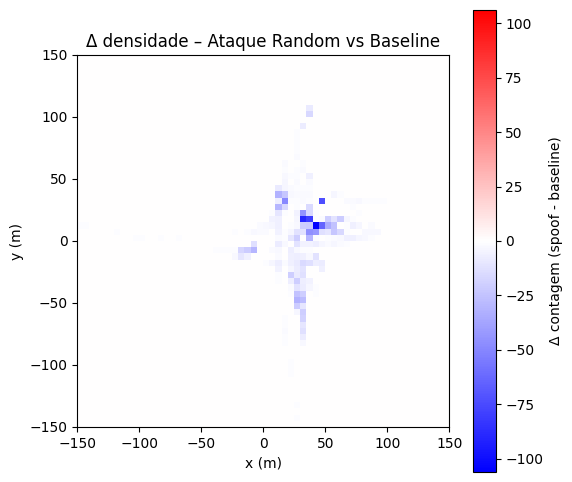

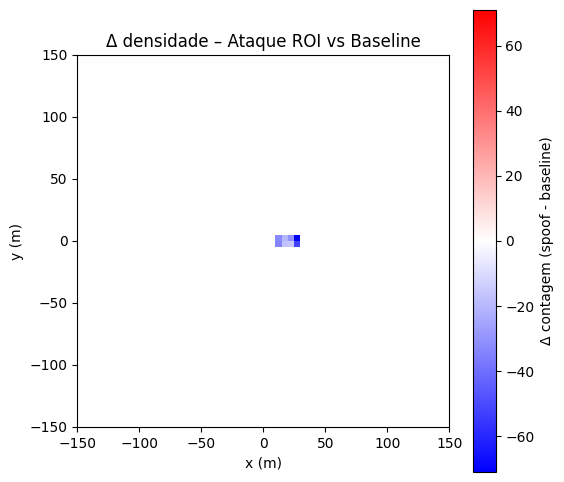

In [29]:
import json
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

# ---------------------------------------------------------
# 1) Carrega todos os centros (x,y) de uma pasta de JSONs
# ---------------------------------------------------------
def collect_xy_from_folder(json_dir):
    """
    Lê todos os arquivos .json em json_dir (formato OpenLABEL TUMTraf)
    e retorna dois arrays: X, Y com os centros das boxes.
    """
    json_dir = Path(json_dir)
    xs, ys = [], []

    for jpath in sorted(json_dir.glob("*.json")):
        with open(jpath, "r") as f:
            data = json.load(f)

        if "openlabel" not in data:
            continue
        frames = data["openlabel"].get("frames", {})
        if not frames:
            continue

        # TUMTraf DevKit: 1 frame por arquivo
        frame_key = list(frames.keys())[0]
        objects = frames[frame_key].get("objects", {})

        for obj_id, obj_data in objects.items():
            cuboid = obj_data.get("object_data", {}).get("cuboid", {})
            val = cuboid.get("val", None)
            if not val or len(val) < 3:
                continue
            x, y = float(val[0]), float(val[1])
            xs.append(x)
            ys.append(y)

    return np.array(xs), np.array(ys)


# ---------------------------------------------------------
# 2) Constroi heatmap 2D (histograma em XY)
# ---------------------------------------------------------
def build_heatmap(xs, ys, xlim=(-150, 150), ylim=(-150, 150), bins=60):
    """
    Retorna (H, xedges, yedges) para uso em comparação.
    Importante: sempre usar MESMO xlim/ylim/bins para todos.
    """
    H, xedges, yedges = np.histogram2d(
        ys, xs,  # ys primeiro para ir no eixo vertical
        bins=bins,
        range=[ylim, xlim]
    )
    return H, xedges, yedges


# ---------------------------------------------------------
# 3) Plota heatmap diferencial (spoof - baseline)
# ---------------------------------------------------------
def plot_heatmap_diff(H_base, H_spoof, xedges, yedges, title):
    """
    Plota (H_spoof - H_base) com colormap divergente.
    Valores positivos = mais objetos no ataque.
    Valores negativos = menos objetos no ataque.
    """
    H_diff = H_spoof - H_base

    vmax = np.max(np.abs(H_diff))
    if vmax == 0:
        vmax = 1.0  # evita divisão por zero / escala degenerada

    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

    plt.figure(figsize=(6, 6))
    im = plt.imshow(
        H_diff,
        origin="lower",
        extent=extent,
        cmap="bwr",        # azul negativo, vermelho positivo
        vmin=-vmax,
        vmax=vmax,
        interpolation="nearest"
    )
    plt.colorbar(im, label="Δ contagem (spoof - baseline)")
    plt.xlabel("x (m)")
    plt.ylabel("y (m)")
    plt.title(title)
    plt.grid(False)
    plt.show()

    return H_diff


# =========================================================
# 4) EXECUÇÃO: baseline + três ataques
# =========================================================

# 4.1. Coleta de centros
xs_base,  ys_base  = collect_xy_from_folder(BASELINE_JSON_DIR)
xs_ph,    ys_ph    = collect_xy_from_folder(INJECT_JSON_DIR)    # phantom
xs_rand,  ys_rand  = collect_xy_from_folder(RANDOM_JSON_DIR)    # remoção aleatória
xs_roi,   ys_roi   = collect_xy_from_folder(ROI_JSON_DIR)       # remoção em ROI

print("Baseline   :", xs_base.shape[0], "objetos")
print("Phantom    :", xs_ph.shape[0],   "objetos")
print("Random del :", xs_rand.shape[0], "objetos")
print("ROI del    :", xs_roi.shape[0],  "objetos")

# 4.2. Gera heatmap BASELINE (referência para todos)
xlim = (-150, 150)
ylim = (-150, 150)
bins = 60

H_base, xedges, yedges = build_heatmap(xs_base, ys_base, xlim=xlim, ylim=ylim, bins=bins)
H_ph,   _,      _      = build_heatmap(xs_ph,   ys_ph,   xlim=xlim, ylim=ylim, bins=bins)
H_rand, _,      _      = build_heatmap(xs_rand, ys_rand, xlim=xlim, ylim=ylim, bins=bins)
H_roi,  _,      _      = build_heatmap(xs_roi,  ys_roi,  xlim=xlim, ylim=ylim, bins=bins)

# 4.3. Opcional – mostrar o baseline bruto
plt.figure(figsize=(6, 6))
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
im = plt.imshow(H_base, origin="lower", extent=extent, cmap="hot")
plt.colorbar(im, label="contagem de objetos")
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.title("Baseline – densidade global (todos os frames)")
plt.show()

# 4.4. Heatmaps DIFERENCIAIS
Hdiff_ph   = plot_heatmap_diff(H_base, H_ph,   xedges, yedges, "Δ densidade – Ataque Phantom vs Baseline")
Hdiff_rand = plot_heatmap_diff(H_base, H_rand, xedges, yedges, "Δ densidade – Ataque Random vs Baseline")
Hdiff_roi  = plot_heatmap_diff(H_base, H_roi,  xedges, yedges, "Δ densidade – Ataque ROI vs Baseline")
